<a href="https://colab.research.google.com/github/newb-dev-1008/Human-PokeDex/blob/master/Crime%20Detection%20-%20Slow%20Fusion%20(Colab).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import argparse
import pickle
import cv2
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Defining the architectures of the first and second layers for temporal convolutions

first_layer = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), strides = 1, input_shape = (262, 262, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.AveragePooling2D(pool_size = (2, 2))
])

second_layer = tf.keras.models.Sequential([
    # input_shape needs to be fixed
    tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), strides = 1, input_shape = first_layer.output.shape[1:]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.AveragePooling2D(pool_size = (2, 2))
])

first_layer.summary()
second_layer.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 260, 260, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 260, 260, 64)      256       
_________________________________________________________________
average_pooling2d (AveragePo (None, 130, 130, 64)      0         
Total params: 2,048
Trainable params: 1,920
Non-trainable params: 128
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      18464     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
______________________________

In [ ]:
def getFusedData(clipData, plot, path, clipName):
    output = []
    flag = 0
    curr = 0
    tenFrames = []
    
    # Loop for each 10 frames in a video clip
    while ((curr + 10) <= len(clipData)):
        tenFrames = clipData[curr : (curr + 10)]
        # print("Tenframes length: ", len(tenFrames))
        # print("Curr: ", curr)

        batch_1 = tenFrames[0 : 4]
        batch_2 = tenFrames[2 : 6]
        batch_3 = tenFrames[4 : 8]
        batch_4 = tenFrames[6 : 10]
        curr += 10

        # Figure out how to input 4 images at once to first_layer
        batch_1_1 = np.stack(np.array(batch_1), axis = 0)
        batch_1_2 = np.stack(np.array(batch_2), axis = 0)
        batch_1_3 = np.stack(np.array(batch_3), axis = 0)
        batch_1_4 = np.stack(np.array(batch_4), axis = 0)

        # print("Input shape: ", batch_1_1.shape)

        out_1_1 = first_layer(batch_1_1)
        out_1_2 = first_layer(batch_1_2)
        out_1_3 = first_layer(batch_1_3)
        out_1_4 = first_layer(batch_1_4)

        # print("First layer output shape: ", out_1_1.shape)
            
        # Plotting the output of the first layer
        if plot:
            square = 4
            ix = 1
            for _ in range(square):
                for _ in range(square):
                    # specify subplot and turn of axis
                    plt.figure(figsize = [20, 10])
                    # plt.title("First Layer Output Maps")
                    ax = plt.subplot(square, square, ix)
                    ax.set_xticks([])
                    ax.set_yticks([])
                    # plot filter channel in grayscale
                    # yplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
                    plt.imshow(out_1_1[0, :, :, ix-1])
                    ix += 1

        batch_2_1 = np.concatenate([out_1_1, out_1_2])
        batch_2_2 = np.concatenate([out_1_3, out_1_4])

        # print("Batch_2_1 shape: ", batch_2_1.shape)

        out_2_1 = second_layer(batch_2_1)
        out_2_2 = second_layer(batch_2_2)
            
        # Plotting the output of the second layer
        if plot:
            plot = False
            square = 4
            ix = 1
            for _ in range(square):
                for _ in range(square):
                    # specify subplot and turn of axis
                    plt.figure(figsize = [20, 10])
                    plt.title("Second Layer Output Maps")
                    ax = plt.subplot(square, square, ix)
                    ax.set_xticks([])
                    ax.set_yticks([])
                    # plot filter channel in grayscale
                    # yplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
                    plt.imshow(out_1_1[0, :, :, ix-1])
                    ix += 1
                
        output_map = np.concatenate([out_2_1, out_2_2])

        if (flag == 0):
            # print("Output map dimensions: ", output_map.shape)
            flag = 1

        output.append(output_map)

        if (path != None):
            # Saving the output numpy array
            filename = clipName + '_' + str(curr) + '.npy'
            with open(filename, 'wb') as f:
                np.save(f, output_map)
    
    return output

Enter the label: Abuse
Tenframes length:  10
Curr:  0
Input shape:  (4, 902, 902, 3)
First layer output shape:  (4, 450, 450, 64)
Batch_2_1 shape:  (8, 450, 450, 64)
Output map dimensions:  (16, 224, 224, 32)


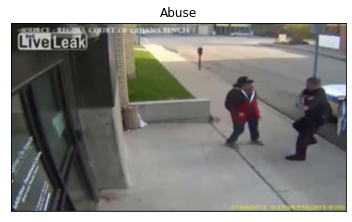

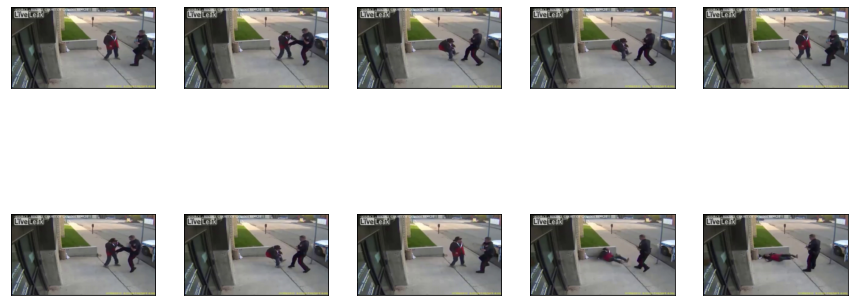

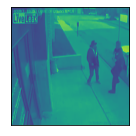

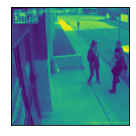

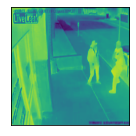

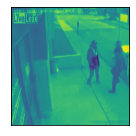

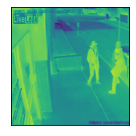

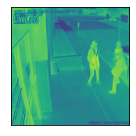

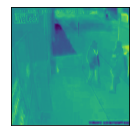

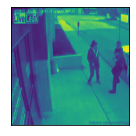

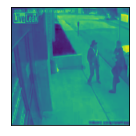

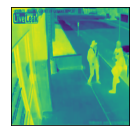

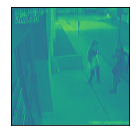

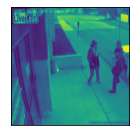

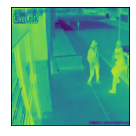

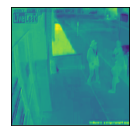

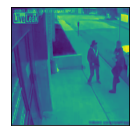

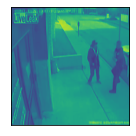

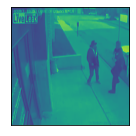

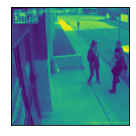

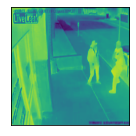

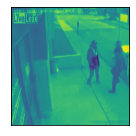

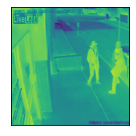

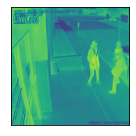

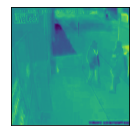

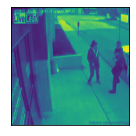

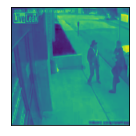

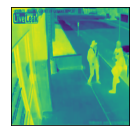

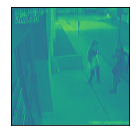

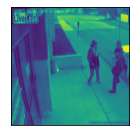

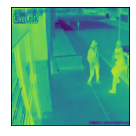

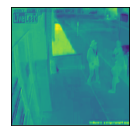

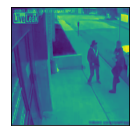

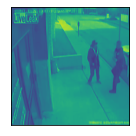

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as pltimg
%matplotlib inline
plt.rcParams.update({'figure.max_open_warning': 0})

# Plot images, their outputs after the first and second layer
# One image

plt.figure()
label = str(input("Enter the label: "))
plt.xticks([])
plt.yticks([])
imagePath = '/content/drive/MyDrive/Datasets/Annotated/' + label
imagePaths = list(paths.list_images(imagePath))
image = pltimg.imread(imagePaths[0])

plt.imshow(image)
plt.title(label)

# Ten images in sequence
i = 0
images_list = []
plt.figure(figsize = [15, 7])
for images in imagePaths[:10]:
    plt.subplot(2, 5, (i + 1))
    image = pltimg.imread(images)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image)
    i += 1
    
    image = cv2.imread(images)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (454, 454))
    images_list.append(image)
    
# Output after first layer
# Output after second layer
_ = getFusedData(images_list, True, None, None)

In [ ]:
import os

LABELS = set(["Abuse", "Assault", "Fighting", "Normal", "Robbery", "Vandalism"])
imgPath = '/content/drive/MyDrive/Datasets/Annotated'
imagePaths = list(paths.list_images('/content/drive/MyDrive/Datasets/Annotated'))

labels = os.listdir(imgPath)
lb = []
out = []

forOutputImage = []
forOutputLabel = []
forOutputMap = []

os.mkdir('/content/drive/MyDrive/Datasets/Output_Maps')
os.chdir('/content/drive/MyDrive/Datasets/Output_Maps')

for label in labels:
    print("--------- Adding ", label, " datasets ---------\n")
    labelClipPath = imgPath + '/' + label
    forOutputLabel.append(label)
    addOutput = 0
    addOutputMap = 0

    # Check if directory exists
    outputPath = '/content/drive/MyDrive/Datasets/Output_Maps/' + label
    os.mkdir(outputPath)
      
    clips = os.listdir(labelClipPath)
    k = 1
    for clip in clips:
        print("Clip No.: ", k)
        clipData = []
        realImagePaths = list(paths.list_images(labelClipPath + '/' + clip))
        
        for imagePath in realImagePaths:
            image = cv2.imread(imagePath)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (262, 262))
            clipData.append(image)

            if (addOutput == 0):
                addOutput = 1
                forOutputImage.append(image)
        
        # Check if directory exists
        finalOutputPath = outputPath + '/' + clip
        os.mkdir(finalOutputPath)
        os.chdir(finalOutputPath)

        output_maps = getFusedData(clipData, False, finalOutputPath, clip)
        
        if (addOutputMap == 0):
            addOutputMap = 1
            forOutputMap.append(output_maps[0])

        # lb += ([realImagePaths[-2]] * len(output_maps))
        # out += output_maps
        del clipData
        del output_maps
        k += 1

    print("--------- ", label, " datasets added. ---------\n")   

FileExistsError: ignored

In [ ]:
# Plot input and corresponding maps for comparison

for i in range(len(forOutputLabel)):
    plt.figure(figsize = [20, 10])
    plt.title(forOutputLabel[i])
    plt.subplot(1, 2, 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(forOutputImage[i])

    plt.subplot(1, 2, 2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(forOutputMap[i])

In [ ]:
main_data = np.array(out)
lbBinarizer = LabelBinarizer()
lb = lbBinarizer.fit_transform(lb)

(trainX, testX, trainY, testY) = train_test_split(data, lb, test_size = 0.25, stratify = labels, random_state = 42)

trainAug = ImageDataGenerator(rotation_range = 30,
                             zoom_range = 0.15,
                             width_shift_range = 0.2,
                             height_shift_range = 0.2,
                             shear_range = 0.15,
                             horizontal_flip = True,
                             fill_mode = "nearest")

valAug = ImageDataGenerator()

mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean
n_epochs = 50

In [ ]:
# Evaluate the network
print("Evaluating network:")
predictions = model.predict(x = testX.astype("float32"), batch_size = 32)

# To print precision, recall, F1 score
print(classification_report(testY.argmax(axis = 1), predictions.argmax(axis = 1), target_names = lb.classes_))

# Plot the training loss and accuracy
N = n_epochs
plt.style.use("ggplot")

plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/ Accuracy")
plt.legend(loc="lower left")

plotPath = r'C:\Users\Yash Umale\Documents\7th Sem\Research Paper\Plots'
plt.savefig(plotPath)

### **Old Parts below**

In [ ]:
LABELS = set(["Abuse", "Assault", "Fighting", "Normal", "Robbery", "Vandalism"])
imagePaths = list(paths.list_images(r'C:\Users\Yash Umale\Documents\7th Sem\Research Paper\Datasets\Annotated'))

data = []
labels = []
clipNos = []

init_clipNo = 1
clipData = []
old_label = ""
old_clipNo = 0

for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-3]
    clipNo = imagePath.split(os.path.sep)[-2]
    
    if (clipNo != init_clipNo):
        init_clipNo = clipNo
        data.append(clipData)
        labels.append(old_label)
        clipNos.append(old_clipNo)
        clipData = []
        
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (902, 902))
        clipData.append(image)
    else:
        old_clipNo = clipNo
        old_label = label
        
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (902, 902))
        clipData.append(image)
    
data.append(clipData)
labels.append(old_label)
clipNos.append(old_clipNo)

error: OpenCV(4.5.1) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-wvn_it83\opencv\modules\core\src\alloc.cpp:73: error: (-4:Insufficient memory) Failed to allocate 6220800 bytes in function 'cv::OutOfMemoryError'


In [ ]:
output = []
lb = []
flag = 0

# Loop for each video clip in the entire dataset
for i in range(len(data)):
    curr = 0
    tenFrames = []
    label = labels[i]
    
    # Loop for each 10 frames in a video clip
    while ((curr + 10) < len(data[i])):
        lb.append(label)
        tenFrames = data[i][curr : (curr + 10)]
        
        batch_1 = tenFrames[curr : curr + 4]
        batch_2 = tenFrames[curr + 2 : curr + 6]
        batch_3 = tenFrames[curr + 4 : curr + 8]
        batch_4 = tenFrames[curr + 6 : curr + 10]
        curr += 10
        
        # Figure out how to input 4 images at once to first_layer
        batch_1_1 = np.stack(np.array(batch_1), axis = 0)
        batch_1_2 = np.stack(np.array(batch_2), axis = 0)
        batch_1_3 = np.stack(np.array(batch_3), axis = 0)
        batch_1_4 = np.stack(np.array(batch_4), axis = 0)
        
        print("Input shape: ", batch_1_1.shape)
        
        # batch_1_1 = batch_1_1.reshape(4, 224, 224, 3)
        # batch_1_2 = batch_1_2.reshape(4, 224, 224, 3)
        # batch_1_3 = batch_1_3.reshape(4, 224, 224, 3)
        # batch_1_4 = batch_1_4.reshape(4, 224, 224, 3)
        
        out_1_1 = first_layer(batch_1_1)
        out_1_2 = first_layer(batch_1_2)
        out_1_3 = first_layer(batch_1_3)
        out_1_4 = first_layer(batch_1_4)
        
        print("First layer output shape: ", out_1_1.shape)
        
        batch_2_1 = np.concatenate([out_1_1, out_1_2])
        batch_2_2 = np.concatenate([out_1_3, out_1_4])
        
        print("Batch_2_1 shape: ", batch_2_1.shape)
        
        out_2_1 = second_layer(batch_2_1)
        out_2_2 = second_layer(batch_2_2)
        output_map = np.concatenate([out_2_1, out_2_2])
        
        if (flag == 0):
            print("Output map dimensions: ", output_map.shape)
            flag = 1
            
        output.append(output_map)

Input shape:  (4, 224, 224, 3)
First layer output shape:  (4, 31, 31, 64)
Batch_2_1 shape:  (8, 31, 31, 64)
Output map dimensions:  (16, 4, 4, 32)


ValueError: need at least one array to stack

In [ ]:
main_data = np.array(output)
lbBinarizer = LabelBinarizer()
lb = lbBinarizer.fit_transform(lb)

(trainX, testX, trainY, testY) = train_test_split(data, lb, test_size = 0.25, stratify = labels, random_state = 42)

trainAug = ImageDataGenerator(rotation_range = 30,
                             zoom_range = 0.15,
                             width_shift_range = 0.2,
                             height_shift_range = 0.2,
                             shear_range = 0.15,
                             horizontal_flip = True,
                             fill_mode = "nearest")

valAug = ImageDataGenerator()

mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean
n_epochs = 50

In [ ]:
# Define a generator to feed images batchwise

def inputGenerator(batch_size, imagePaths, shuffle_data = True):
    num_samples = len(imagePaths)

    if (shuffle_data):
        shuffle(imagePaths)

    for offset in range(0, num_samples, batch_size):
        batch_samples = imagePaths[offset, offset + batch_size]

        X_train, y_train = [], []

        for batch_sample in batch_samples:
            img_path = batch_sample[0]
            label = batch_labels[1]

            image = np.load(img_path)
            X_train.append(image)
            y_train.append(label)
        
        X_train = np.array(X_train)
        y_train = np.array(y_train)

        yield X_train, y_train

In [ ]:
# Calling the generator

imgPaths = []
inputData = # Path to folder containing 64 x 64 numpy array files
images = []
lbls = []

for labelFolder in os.listdir(inputData):
    arrPaths = []
    for output_map in os.listdir((inputData + "/" + labelFolder)):
        arrPaths.append(output_map)
        arrPaths.append(labelFolder)
        images.append(output_map)
        lbls.append(labelFolder)
    imgPaths.append(arrPaths)

imgPaths = np.array(imgPaths)

# Creating train and test subsets
(x_train, x_test, y_train, y_test) = train_test_split(images, lbls, test_size = 0.25, shuffle = True, stratify = None, random_state = 42)

In [ ]:
with tf.device('/gpu:0'):
    baseModel = ResNet50(weights = "imagenet", include_top = False,
        input_tensor = Input(shape = output_map.shape[1:]))

    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size = (7, 7))(headModel)
    headModel = Flatten(name = "flatten")(headModel)
    headModel = Dense(512, activation = "relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(len(lb.classes_), activation = "softmax")(headModel)

    model = Model(inputs=baseModel.input, outputs=headModel)

    for layer in baseModel.layers:
        layer.trainable = False

    print("Compiling model:")
    opt = SGD(lr = 1e-4, momentum = 0.9, decay = (1e-4 / n_epochs))
    model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])

    '''
    print("Training head:")
    H = model.fit(
        x = trainAug.flow(trainX, trainY, batch_size = 32),
        steps_per_epoch = len(trainX) // 32,
        validation_data = valAug.flow(testX, testY),
        validation_steps = len(testX) // 32,
        epochs = n_epochs)
    '''
    
    H = model.fit(
        x = inputGenerator(4, x_train, True),
        steps_per_epoch = len(x_train) // 4,
        validation_data = inputGenerator(4, x_test, True),
        validation_steps = len(x_test) // 4,
        epochs = n_epochs)

In [ ]:
# Evaluate the network
print("Evaluating network:")
predictions = model.predict(x = x_test.astype("float32"), batch_size = 4)

# To print precision, recall, F1 score
print(classification_report(y_test.argmax(axis = 1), predictions.argmax(axis = 1), target_names = lb.classes_))

# Plot the training loss and accuracy
N = n_epochs
plt.style.use("ggplot")

plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/ Accuracy")
plt.legend(loc="lower left")

plotPath = r'C:\Users\Yash Umale\Documents\7th Sem\Research Paper\Plots'
plt.savefig(plotPath)